# Goal: Train a Naive Bayes model to classify future SMS messages as either spam or ham.

Steps:  
- Convert the words ham and spam to a binary indicator variable(0/1)  
- Convert the txt to a sparse matrix of TFIDF vectors  
- Fit a Naive Bayes Classifier  
- Measure your success using roc_auc_score

In [77]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [78]:
df= pd.read_csv("../data/SMSSpamCollection",sep='\t', names=['spam', 'txt'])

In [79]:
df.head()

,spam,txt
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [80]:
df.shape

(5572, 2)

In [81]:
df.describe()

,spam,txt
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [82]:
df.isnull().any()

spam    False
txt     False
dtype: bool

In [83]:
df['spam']=pd.get_dummies(df.spam)['spam']

In [84]:
df.head()

,spam,txt
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [85]:
stopset = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii', stop_words=stopset)

In [86]:
y = df.spam

In [87]:
X = vectorizer.fit_transform(df.txt)

In [88]:
print (y.shape)
print (X.shape)

(5572,)
(5572, 8587)


In [89]:
X_train, X_test,y_train, y_test = train_test_split(X, y, random_state=42)

In [90]:
clf = naive_bayes.MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [91]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.98589322144123448

In [92]:
textmsgs = np.array(["Congratulations, you've been selected to"])
textmsgs_vector = vectorizer.transform(textmsgs)
print (clf.predict(textmsgs_vector))

[1]


In [102]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
grid = {'alpha': alphas, 'fit_prior' : [True, False], 'class_prior' : [None, [.1,.9],[.2, .8]]}

clf = naive_bayes.MultinomialNB()

estimator = GridSearchCV(estimator = clf, param_grid = grid, scoring = 'roc_auc', cv = 5)

In [103]:
estimator.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'fit_prior': [True, False], 'class_prior': [None, [0.1, 0.9], [0.2, 0.8]]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [104]:
estimator.best_estimator_

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [105]:
best_NB = estimator.best_estimator_

In [106]:
roc = roc_auc_score(y_test, best_NB.predict_proba(X_test)[:,1])
print ("AUC Score: ", roc)

AUC Score:  0.992343052623


In [110]:
import seaborn as sns
sns.set_style('white')

In [114]:
features = vectorizer.get_feature_names()

In [115]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [118]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [120]:
top_feats_in_doc(X_train,features,0,top_n=25)

,feature,tfidf
0,claim,0.341723
1,receivea,0.295267
2,09061701461,0.295267
3,kl341,0.295267
4,reward,0.253577
5,900,0.250277
6,12,0.244492
7,valued,0.241926
8,winner,0.235203
9,hours,0.226275


In [121]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [122]:
top_mean_feats(X_train,features)

,feature,tfidf
0,call,0.019674
1,ok,0.017661
2,get,0.014284
3,come,0.011610
4,ur,0.011472
5,lt,0.011328
6,gt,0.011280
7,good,0.010474
8,later,0.010071
9,know,0.010016


In [125]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [129]:
dfs = top_feats_by_class(X_train,y_train,features)

In [130]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

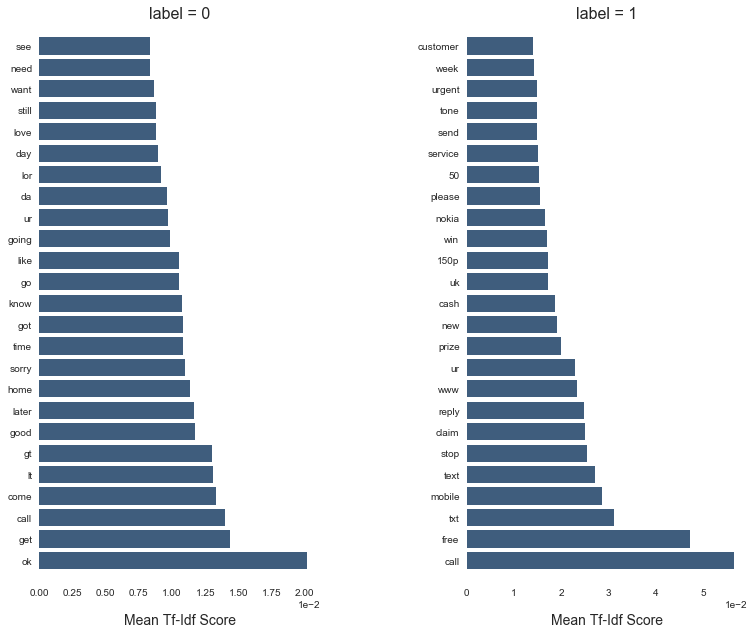

In [131]:
plot_tfidf_classfeats_h(dfs)